# **Ujian Modul 3**

---



# **1. Problem Framing**

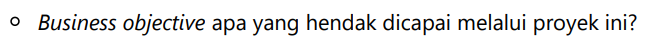

Mendapatkan utilisasi kamar yang efektif dan tidak ada waste, serta dapat memprediksi customer yang akan melakukan pembatalan dalam reservasi kamar

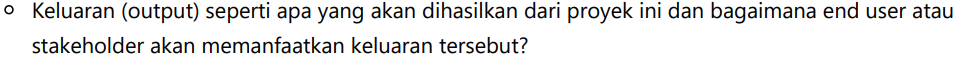

Output yang diharapkan adalah ketika kami mendapatkan input reservasi dari customer kami dapat memprediksi customer akan melakukan pembatalan dalam reservasi tersebut atau tidak

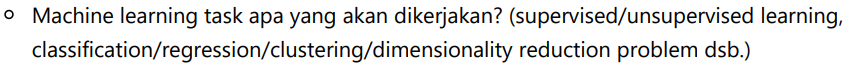

Supervised Learning dengan menggunakan metode K-Nearest Neighbor, Decision Tree, dan AdaBoost

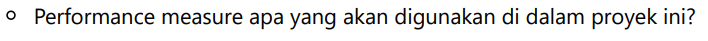

Performance Measure:
1. Precision
2. Recall
3. F1 Score
4. Accuracy

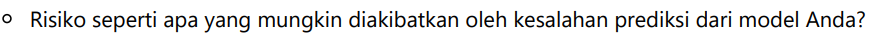

Terdapat 2 resiko yang mungkin diakibatkan jika salah prediksi:
1. Tamu yang kecewa disebabkan pembatalan yang dapat terjadi
2. Tamu yang seharusnya batal, tapi dianggap ada kamar sehingga menjadi waste

## Import Library

In [3]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.7MB/s 


In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile
from sklearn import metrics
from sklearn.metrics import classification_report
import category_encoders as ce
from sklearn.model_selection import cross_val_score

In [5]:
from google.colab import files
upload = files.upload()

Saving hotel_bookings.csv to hotel_bookings.csv


# **2. EDA**

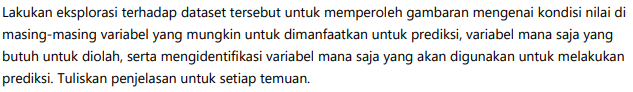

In [19]:
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [20]:
df.shape

(119390, 32)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [22]:
df.sample(frac=0.5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
63581,City Hotel,1,97,2017,February,7,14,0,4,2,0.0,0,BB,BRA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,93.60,0,1,Canceled,2017-01-26
5326,Resort Hotel,1,138,2016,April,18,25,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,E,E,0,Non Refund,NaN,NaN,0,Transient,65.00,0,0,Canceled,2016-01-18
60297,City Hotel,1,277,2016,November,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NaN,NaN,0,Transient,100.00,0,0,Canceled,2016-04-04
12181,Resort Hotel,1,310,2017,June,24,16,3,7,2,0.0,0,BB,IRL,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,80.10,0,0,Canceled,2016-08-11
83775,City Hotel,0,0,2016,February,7,10,0,2,2,1.0,0,BB,GBR,Direct,Direct,0,0,0,A,D,0,No Deposit,NaN,NaN,0,Transient,104.00,0,0,Check-Out,2016-02-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,Resort Hotel,0,0,2016,February,6,1,1,1,1,0.0,0,HB,PRT,Corporate,Corporate,1,0,1,A,A,0,No Deposit,NaN,20.0,0,Transient,46.00,0,0,Check-Out,2016-02-03
37165,Resort Hotel,0,146,2017,May,22,31,2,7,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,241.0,NaN,0,Transient,102.38,0,1,Check-Out,2017-06-09
96238,City Hotel,0,6,2016,August,36,28,2,1,2,2.0,0,BB,ESP,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,9.0,NaN,0,Transient,228.00,0,3,Check-Out,2016-08-31
9641,Resort Hotel,1,248,2016,December,52,22,2,3,1,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,NaN,0,Transient,55.80,0,0,Canceled,2016-07-19


In [23]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [24]:
#Mengisi data null
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
df_clean = df.fillna(nan_replacements)

In [25]:
df_clean['meal'].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [27]:
#Mengganti data 'undefined' menjadi 'SC'
df_clean["meal"].replace("Undefined", "SC", inplace=True)

In [28]:
#Menghapus data yang tidak ada tamu

zero_guests = list(df_clean.loc[df_clean["adults"]
                   + df_clean["children"]
                   + df_clean["babies"]==0].index)

df_clean.drop(df_clean.index[zero_guests], inplace=True)

In [30]:
df_clean.shape

(119210, 32)

In [31]:
#Check duplicate Data

duplicate = df_clean.duplicated().any()

In [32]:
print("Apakah ada data yang duplikat:", duplicate)

Apakah ada data yang duplikat: True


In [33]:
#Drop duplicate data

df_clean = df_clean.drop_duplicates()

In [34]:
df_clean.shape

(87230, 32)

In [35]:
df_clean.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87226.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000,87230.000000
mean,0.275238,79.971019,2016.210352,26.835091,15.815832,1.004609,2.623925,1.879365,0.138904,0.010845,0.038565,0.030402,0.184054,0.268497,81.089258,10.984948,0.746291,106.518031,0.084306,0.698934
std,0.446637,86.058683,0.686064,13.669216,8.835545,1.027408,2.039830,0.621724,0.456274,0.113704,0.192556,0.369344,1.733033,0.710633,109.977255,53.956668,10.001001,54.891227,0.281659,0.832051
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,11.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,72.250000,0.000000,0.000000
50%,0.000000,49.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,98.200000,0.000000,0.000000
75%,1.000000,125.000000,2017.000000,37.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,0.000000,0.000000,134.100000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


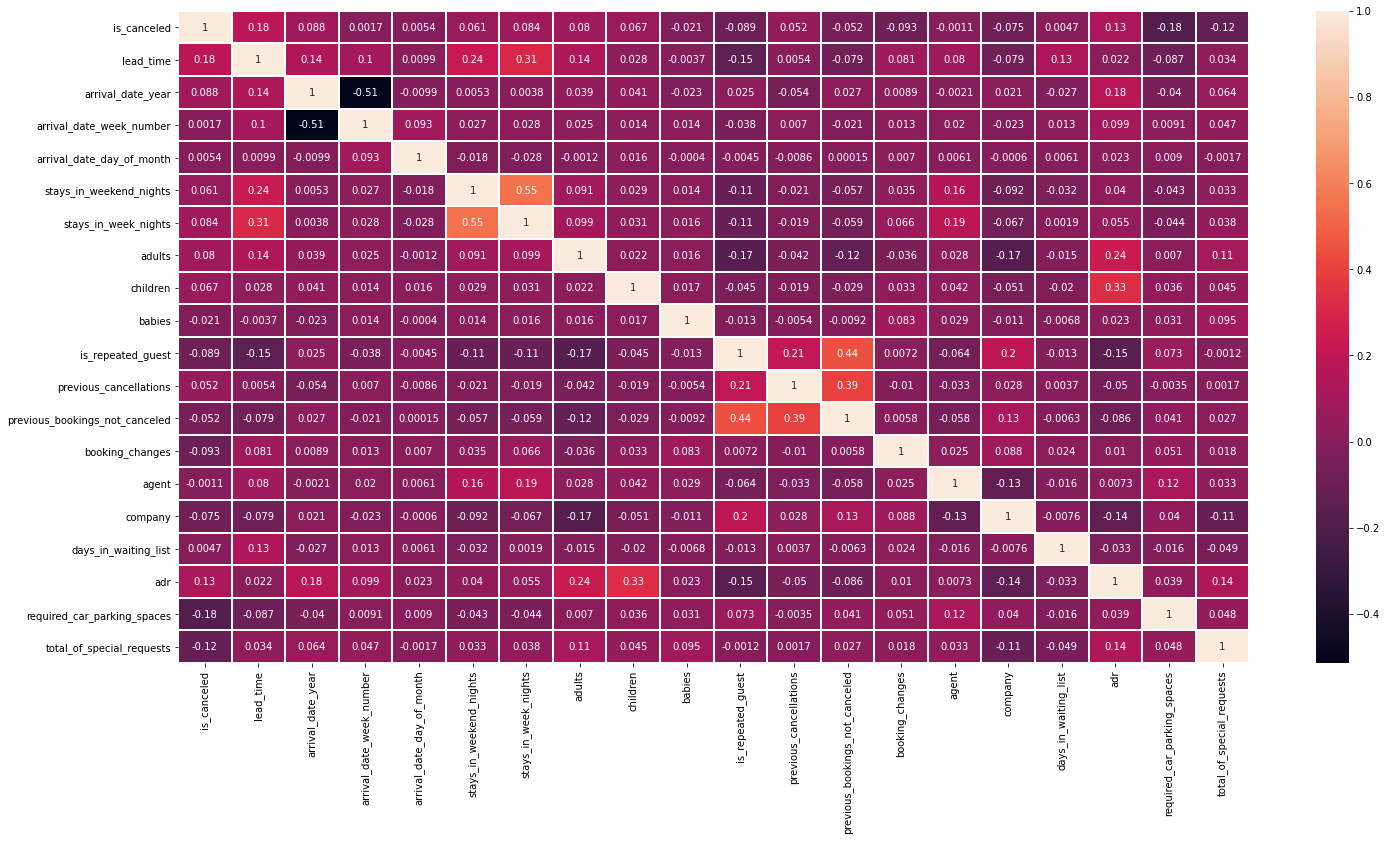

In [37]:
plt.figure(figsize = (24, 12))

corr = df_clean.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [39]:
correlation = df_clean.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.184515
required_car_parking_spaces       0.184456
adr                               0.127233
total_of_special_requests         0.120794
booking_changes                   0.093236
is_repeated_guest                 0.088764
arrival_date_year                 0.088020
stays_in_week_nights              0.084159
adults                            0.080271
company                           0.075314
children                          0.067209
stays_in_weekend_nights           0.060992
previous_bookings_not_canceled    0.052178
previous_cancellations            0.051501
babies                            0.020627
arrival_date_day_of_month         0.005449
days_in_waiting_list              0.004710
arrival_date_week_number          0.001691
agent                             0.001145
Name: is_canceled, dtype: float64

## **3. Data Preparation**

In [40]:
useless_col = ['days_in_waiting_list', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status', 'country', 'days_in_waiting_list']

df_clean.drop(useless_col, axis = 1, inplace = True)

In [41]:
df_clean.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,July,27,1,0,0,2,0.0,0,BB,Direct,Direct,0,0,0,C,No Deposit,0.0,0.0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,0,737,July,27,1,0,0,2,0.0,0,BB,Direct,Direct,0,0,0,C,No Deposit,0.0,0.0,Transient,0.0,0,0,2015-07-01
2,Resort Hotel,0,7,July,27,1,0,1,1,0.0,0,BB,Direct,Direct,0,0,0,A,No Deposit,0.0,0.0,Transient,75.0,0,0,2015-07-02
3,Resort Hotel,0,13,July,27,1,0,1,1,0.0,0,BB,Corporate,Corporate,0,0,0,A,No Deposit,304.0,0.0,Transient,75.0,0,0,2015-07-02
4,Resort Hotel,0,14,July,27,1,0,2,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,No Deposit,240.0,0.0,Transient,98.0,0,1,2015-07-03


In [53]:
category_column = [col for col in df_clean.columns if df_clean[col].dtype == 'O']
category_column

['hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date']

In [54]:
df_category = df_clean[category_column]
df_category.head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,reservation_status_date
0,Resort Hotel,July,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
1,Resort Hotel,July,BB,Direct,Direct,C,No Deposit,Transient,2015-07-01
2,Resort Hotel,July,BB,Direct,Direct,A,No Deposit,Transient,2015-07-02
3,Resort Hotel,July,BB,Corporate,Corporate,A,No Deposit,Transient,2015-07-02
4,Resort Hotel,July,BB,Online TA,TA/TO,A,No Deposit,Transient,2015-07-03


In [55]:
df_category['reservation_status_date'] = pd.to_datetime(df_category['reservation_status_date'])

df_category['year'] = df_category['reservation_status_date'].dt.year
df_category['month'] = df_category['reservation_status_date'].dt.month
df_category['day'] = df_category['reservation_status_date'].dt.day

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [56]:
df_category.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
df_category.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
1,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient,2015,7,2
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient,2015,7,2
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient,2015,7,3


In [58]:
for i in df_category.columns:
    print(f"{id}: \n{df_category[i].unique()}\n")

<built-in function id>: 
['Resort Hotel' 'City Hotel']

<built-in function id>: 
['BB' 'FB' 'HB' 'SC']

<built-in function id>: 
['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

<built-in function id>: 
['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

<built-in function id>: 
['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']

<built-in function id>: 
['No Deposit' 'Refundable' 'Non Refund']

<built-in function id>: 
['Transient' 'Contract' 'Transient-Party' 'Group']

<built-in function id>: 
[2015 2014 2016 2017]

<built-in function id>: 
[ 7  5  4  6  3  8  9  1 11 10 12  2]

<built-in function id>: 
[ 1  2  3  6 22 23  5  7  8 11 15 16 29 19 18  9 13  4 12 26 17 10 20 14
 30 28 25 21 27 24 31]



In [59]:
#Encoding df_category using ordinal encoding

df_category['hotel'] = df_category['hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

df_category['meal'] = df_category['meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

df_category['market_segment'] = df_category['market_segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

df_category['distribution_channel'] = df_category['distribution_channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

df_category['reserved_room_type'] = df_category['reserved_room_type'].map({'C': 0, 'A': 1, 'D': 2, 'E': 3, 'G': 4, 'F': 5, 'H': 6,
                                                                   'L': 7, 'B': 8})

df_category['deposit_type'] = df_category['deposit_type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

df_category['customer_type'] = df_category['customer_type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

df_category['year'] = df_category['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [78]:
df_category

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,0,0,0,0,0,0,0,0,7,1
1,0,0,0,0,0,0,0,0,7,1
2,0,0,0,0,1,0,0,0,7,2
3,0,0,1,1,1,0,0,0,7,2
4,0,0,2,2,1,0,0,0,7,3
...,...,...,...,...,...,...,...,...,...,...
119385,1,0,3,2,1,0,0,3,9,6
119386,1,0,2,2,3,0,0,3,9,7
119387,1,0,2,2,2,0,0,3,9,7
119388,1,0,2,2,1,0,0,3,9,7


In [62]:
df_num = df_clean.drop(columns = category_column, axis = 1)
df_num.drop('is_canceled', axis = 1, inplace = True)
df_num

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
0,342,27,1,0,0,2,0.0,0,0,0,0,0.0,0.0,0.00,0,0
1,737,27,1,0,0,2,0.0,0,0,0,0,0.0,0.0,0.00,0,0
2,7,27,1,0,1,1,0.0,0,0,0,0,0.0,0.0,75.00,0,0
3,13,27,1,0,1,1,0.0,0,0,0,0,304.0,0.0,75.00,0,0
4,14,27,1,0,2,2,0.0,0,0,0,0,240.0,0.0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,35,30,2,5,2,0.0,0,0,0,0,394.0,0.0,96.14,0,0
119386,102,35,31,2,5,3,0.0,0,0,0,0,9.0,0.0,225.43,0,2
119387,34,35,31,2,5,2,0.0,0,0,0,0,9.0,0.0,157.71,0,4
119388,109,35,31,2,5,2,0.0,0,0,0,0,89.0,0.0,104.40,0,0


In [68]:
numerical_column = [col for col in df_num]
numerical_column

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'agent',
 'company',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [70]:
minmax = MinMaxScaler()

df_num_scaled = minmax.fit_transform(df_num)
df_num_scaled = pd.DataFrame(df_num_minmax, columns=numerical_column)
df_num_scaled

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,adr,required_car_parking_spaces,total_of_special_requests
0,0.464043,0.500000,0.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001180,0.0,0.0
1,1.000000,0.500000,0.000000,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001180,0.0,0.0
2,0.009498,0.500000,0.000000,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.015053,0.0,0.0
3,0.017639,0.500000,0.000000,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0.568224,0.0,0.015053,0.0,0.0
4,0.018996,0.500000,0.000000,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,0.0,0.448598,0.0,0.019307,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87225,0.031208,0.653846,0.966667,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.0,0.736449,0.0,0.018963,0.0,0.0
87226,0.138399,0.653846,1.000000,0.105263,0.10,0.054545,0.0,0.0,0.0,0.0,0.0,0.016822,0.0,0.042877,0.0,0.4
87227,0.046133,0.653846,1.000000,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.0,0.016822,0.0,0.030351,0.0,0.8
87228,0.147897,0.653846,1.000000,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.0,0.166355,0.0,0.020491,0.0,0.0


In [99]:
df_category.shape , df_num_scaled.shape

((87230, 10), (87230, 16))

In [102]:
df_category.reset_index(drop=True,inplace=True)
df_num_scaled.reset_index(drop=True,inplace=True)

In [105]:
df_concat = pd.concat([df_category,df_num_scaled], axis=1)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87230 entries, 0 to 87229
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87230 non-null  int64  
 1   meal                            87230 non-null  int64  
 2   market_segment                  87230 non-null  int64  
 3   distribution_channel            87230 non-null  int64  
 4   reserved_room_type              87230 non-null  int64  
 5   deposit_type                    87230 non-null  int64  
 6   customer_type                   87230 non-null  int64  
 7   year                            87230 non-null  int64  
 8   month                           87230 non-null  int64  
 9   day                             87230 non-null  int64  
 10  lead_time                       87230 non-null  float64
 11  arrival_date_week_number        87230 non-null  float64
 12  arrival_date_day_of_month       

In [115]:
df_concat.isna().sum()

hotel                             0
meal                              0
market_segment                    0
distribution_channel              0
reserved_room_type                0
deposit_type                      0
customer_type                     0
year                              0
month                             0
day                               0
lead_time                         0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
agent                             0
company                           0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

In [116]:
df_concat['children']=df_concat['children'].fillna(0)

In [117]:
df_concat.isna().sum()

hotel                             0
meal                              0
market_segment                    0
distribution_channel              0
reserved_room_type                0
deposit_type                      0
customer_type                     0
year                              0
month                             0
day                               0
lead_time                         0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
agent                             0
company                           0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

## **4. Model Training**

In [118]:
X = df_concat
y = df_clean['is_canceled']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

In [130]:
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(max_depth=5)
ada = AdaBoostClassifier(n_estimators=100)

### Predict Without Cross Validation

In [131]:
knn = knn.fit(X_train,y_train)
knn_y_pred = knn.predict(X_test)
print('KNN Accuracy:',metrics.accuracy_score(y_test, knn_y_pred))

KNN Accuracy: 0.8143222897321258


In [132]:
dt = dt.fit(X_train,y_train)
dt_y_pred = dt.predict(X_test)
print('Decision Tree Accuracy:',metrics.accuracy_score(y_test, dt_y_pred))

Decision Tree Accuracy: 0.7874966563491154


In [134]:
ada = ada.fit(X_train,y_train)
ada_y_pred = ada.predict(X_test)
print('AdaBoost Accuracy:',metrics.accuracy_score(y_test, ada_y_pred))

AdaBoost Accuracy: 0.8225381176200849


In [135]:
print('KNN Classification Report:')
print(classification_report(y_test,knn_y_pred))
print('Decision Tree Classification Report:')
print(classification_report(y_test,dt_y_pred))
print('AdaBoost Classification Report:')
print(classification_report(y_test,ada_y_pred))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     19034
           1       0.76      0.47      0.58      7135

    accuracy                           0.81     26169
   macro avg       0.79      0.71      0.73     26169
weighted avg       0.81      0.81      0.80     26169

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     19034
           1       0.66      0.45      0.54      7135

    accuracy                           0.79     26169
   macro avg       0.74      0.68      0.70     26169
weighted avg       0.77      0.79      0.77     26169

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     19034
           1       0.77      0.50      0.61      7135

    accuracy                           0.82     26169
   macro avg       0.80      0.7

### Predict With Cross Validation

### KNN

In [136]:
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
scores

array([0.80907156, 0.80707501, 0.80691123, 0.80658369, 0.80232558,
       0.80461841, 0.80461841, 0.79921389, 0.79823125, 0.81067802])

In [137]:
scores.mean()

0.8049327043636222

In [141]:
k_range = range(1,20)

k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8358690024618831, 0.8182801080265778, 0.8173137675639328, 0.8032785856076516, 0.8049327043636222, 0.7954503782877156, 0.7993809303473363, 0.7940419758546557, 0.8004946078158204, 0.796449470736169, 0.8038027434219674, 0.7991352542503967, 0.8069634991145727, 0.8025908180412517, 0.8094855790161167, 0.8047034753254696, 0.8108285042948733, 0.805358555267615, 0.8111560482885432]


Text(0, 0.5, 'Cross-Validated Accuracy')

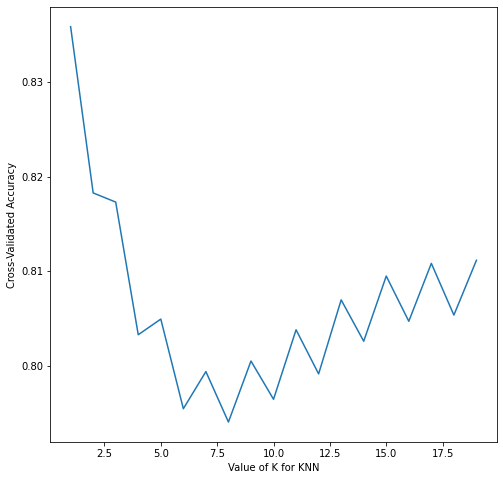

In [152]:
plt.figure(figsize=(8,8))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [144]:
knn = KNeighborsClassifier(n_neighbors=1)

knn = knn.fit(X_train,y_train)
knn_y_pred = knn.predict(X_test)
print('KNN Accuracy:',metrics.accuracy_score(y_test, knn_y_pred))

KNN Accuracy: 0.8434407122931713


Berdasarkan Plot Cross Validation pada KNN, n-neighbors = 1 mendapatkan cv accuracy tertinggi yaitu 0.84

### Decision Tree

In [145]:
scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy')
scores 

array([0.77959718, 0.78840485, 0.78971503, 0.79020635, 0.78398297,
       0.78922371, 0.78169014, 0.78693089, 0.78955126, 0.79168031])

In [146]:
scores.mean()

0.7870982705996796

In [149]:
depth_range = range(1, 30)

max_depth_scores = []

for d in depth_range:
    dt = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy')
    max_depth_scores.append(scores.mean())

print(max_depth_scores)

[0.7236533967266036, 0.7236533967266036, 0.7236533967266036, 0.7610095828454146, 0.7870982705996796, 0.7920932581754861, 0.7957780831852704, 0.8189025083896627, 0.8275331889739433, 0.8341331633044101, 0.8458263865315725, 0.8643815704766258, 0.8724717802743743, 0.8870310020487893, 0.8935982512107616, 0.9026547156557495, 0.9078789939495312, 0.9165587958081962, 0.92197966110531, 0.9251731446481409, 0.9271220393215842, 0.9284977594938522, 0.9291691953159162, 0.9293820657924187, 0.9291527616657863, 0.9296604885117038, 0.9294311817033403, 0.9290545003448974, 0.9294803297950391]


Text(0, 0.5, 'Cross-Validated Accuracy')

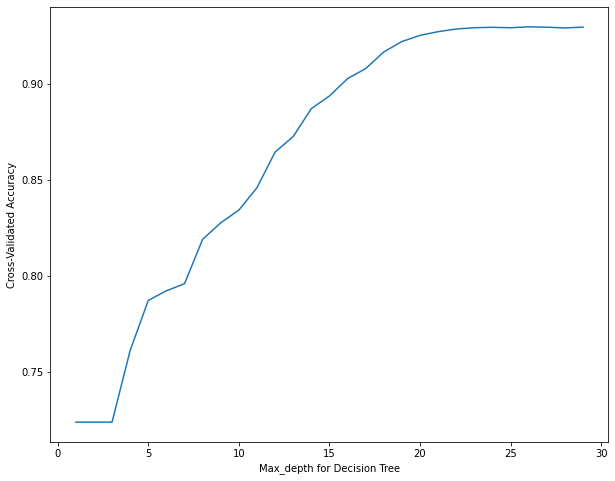

In [150]:
plt.figure(figsize=(10,8))
plt.plot(depth_range, max_depth_scores)
plt.xlabel('Max_depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

In [151]:
dt = DecisionTreeClassifier(max_depth=23)

dt = dt.fit(X_train,y_train)
dt_y_pred_cv = dt.predict(X_test)
print('Decision Tree Accuracy:',metrics.accuracy_score(y_test, dt_y_pred_cv))

Decision Tree Accuracy: 0.9319041614123581


Berdasarkan Plot Cross Validation pada Decision Tree, max depth memuncak di angka 23 dan mendapatkan cv accuracy tertinggi yaitu 0.93. Perbedaan yang cukup signifikan ketika melakukan prediksi sebelum menggunakan CV (0.78)

### AdaBoost

In [153]:
scores = cross_val_score(ada, X_train, y_train, cv=10, scoring='accuracy')
scores 

array([0.82511872, 0.82427121, 0.82623649, 0.82034065, 0.82165084,
       0.81984933, 0.8175565 , 0.82165084, 0.82607272, 0.82934818])

In [154]:
scores.mean()

0.8232095460413327

## **5. Evaluation, Model Selection, and Model Tuning**

Setelah dievaluasi dari ke-3 Model (KNN, Decision Tree, AdaBoost)
Maka model terbaik yang dipilih adalah:


*   **Decision Tree** 



Maka dilakukan model pada Decision Tree dilakukan tuning menggunakan RandomizedSearch

In [160]:
param_grid_dt = {
    'criterion':['gini','entropy'],
    'max_depth':range(15,30),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,9)
}

gs_dt = RandomizedSearchCV(
    dt,
    param_grid_dt,
    verbose = 1,
    cv = 3,
    n_jobs=-1
    )

gs_dt_results = gs_dt.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.0s finished


In [164]:
gs_dt_results.best_params_

{'criterion': 'entropy',
 'max_depth': 29,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [165]:
gs_dt_results.best_score_

0.9331651055731814

In [166]:
gs_dt_results.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=29, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

**Sebelum dilakukan tuning**

In [169]:
dt = DecisionTreeClassifier(max_depth=5)

dt = dt.fit(X_train,y_train)
dt_y_pred = dt.predict(X_test)
print('Decision Tree Accuracy:',metrics.accuracy_score(y_test, dt_y_pred))
print('Decision Tree Classification Report:')
print(classification_report(y_test,dt_y_pred))

Decision Tree Accuracy: 0.7876112958080171
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     19034
           1       0.66      0.45      0.54      7135

    accuracy                           0.79     26169
   macro avg       0.74      0.68      0.70     26169
weighted avg       0.77      0.79      0.77     26169



**Setelah dilakukan tuning** 

In [168]:
dt = DecisionTreeClassifier(max_depth=29,criterion='entropy',min_samples_leaf=1,min_samples_split=2)

dt = dt.fit(X_train,y_train)
dt_y_pred = dt.predict(X_test)
print('Decision Tree Accuracy using best param:',metrics.accuracy_score(y_test, dt_y_pred))

print('Decision Tree Classification Report:')
print(classification_report(y_test,dt_y_pred))

Decision Tree Accuracy using best param: 0.9414192365012037
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19034
           1       0.90      0.88      0.89      7135

    accuracy                           0.94     26169
   macro avg       0.93      0.92      0.93     26169
weighted avg       0.94      0.94      0.94     26169



**Decision Tree Training Accuracy**

In [172]:
dt = DecisionTreeClassifier(max_depth=29,criterion='entropy',min_samples_leaf=1,min_samples_split=2)

dt = dt.fit(X_train,y_train)
dt_y_pred = dt.predict(X_train)
print('Decision Tree Training Accuracy:',metrics.accuracy_score(y_train, dt_y_pred))

Decision Tree Training Accuracy: 0.9994923109677208


## **6. Result, Conclusion, and Recommendation**

Dalam model Machine Learning ada beberapa metode yang diterapkan:


*   Menganalisa dataset terlebih dahulu yaitu terdapat masalah dalam reservasi kamar hotel
*   Melakukan feature selection berdasarkan korelasi fitur dengan target
*   Membagi feature yang berisi data kategorikal dan numerikal dan melakukan ordinal encoding pada data kategorikal (disebabkan karena mayoritas fitur memiliki 'type' yang menunjukan level terhadap setiap value, dan melakukan minmax scaling pada data numerikal
*   Pada Model training menggunakan 3 yaitu KNN, Decision Tree, dan AdaBoost. Kemudian memilih model Decision Tree karena memiliki performance terbaik diantara 2 lainnya.

**Conclusion**

Decision Tree merupakan model paling baik diantara lainnya dikarenakan mendapatkan hasil accuracy 0.78 dan setelah dituning mendapatkan accuracy 0.94 dengan training accuracy 0.99. Berdasarkan dari perbandingan antara training dan testing bisa dikatakan bahwa model ini good fit dan tidak adanya overfitting atau underfitting.

Kemudian didapatkan dalam classification report F1 Score, precision dan recall 0.96





